# Color Bias

In [33]:
!pip install timm transformers

Imports


In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision import models
from tqdm import tqdm
import timm
from transformers import CLIPProcessor, CLIPModel

import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image, ImageOps
import cv2
import os

from torchvision import datasets
from torchvision.transforms import ToTensor

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Device Agnostic


In [35]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load Dataset

In [36]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor()
])

In [37]:
# Load the dataset
train_dataset = torchvision.datasets.Caltech101(
    root='./data',
    download=True,
    transform=transform,
    target_type="category"
)

print(f"Dataset size: {len(train_dataset)}")

# Splitting the dataset into training and validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
classes = train_dataset.dataset.categories  # List of categories


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Files already downloaded and verified
Dataset size: 8677


In [38]:
print(classes)
print(len(classes))

['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

Color Inversion Transformation

In [39]:
def invert_colors_transform(image):
    # Convert tensor to PIL Image if necessary
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)

    # Invert colors using PIL's ImageOps
    inverted_image = ImageOps.invert(image)

    # Convert the inverted image back to a tensor
    return TF.to_tensor(inverted_image)

Generating Dataset of Inverted Images

In [40]:
class CaltechInvertedDataset(Dataset):
    def __init__(self, dataset, transform=None, inverse_transform_func=None):
        self.dataset = dataset  # Use the already split dataset (validation set)
        self.transform = transform
        self.inverse_transform_func = inverse_transform_func

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the original image and its label
        image, label = self.dataset[idx]
        class_label = classes[label]

        # Apply the normal transform to the original image
        if self.transform:
            image = self.transform(image)

        # Apply inversion transform
        if self.inverse_transform_func:
            inverted_image = self.inverse_transform_func(image)
        else:
            inverted_image = image

        return image, inverted_image, label, class_label


In [41]:
root_dir = "/content/data/caltech101/101_ObjectCategories"  # Path to Caltech101 dataset

# Transform for both original and inverted datasets (resize and convert to tensor)
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale images to RGB
    # transforms.ToTensor()
])

# Apply the inversion transformation only to the validation set
caltech_inverted_val_dataset = CaltechInvertedDataset(dataset=val_dataset, transform=transform, inverse_transform_func=invert_colors_transform)


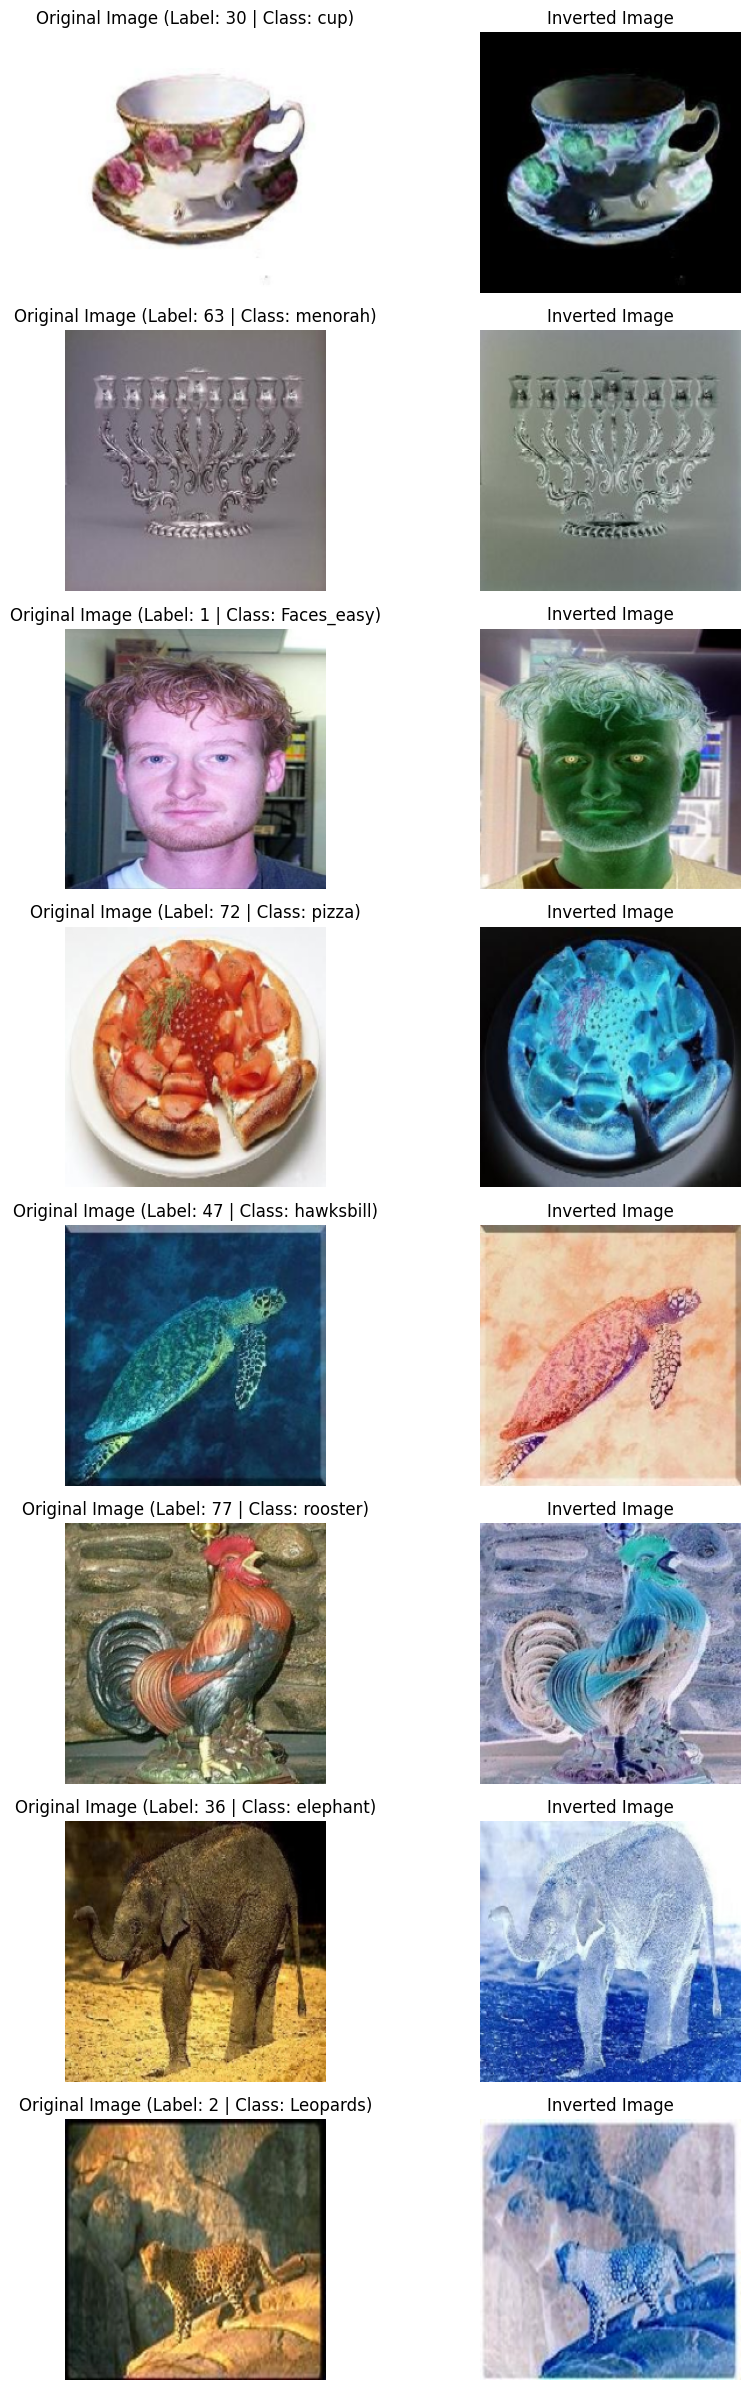

In [42]:
# Create a DataLoader for the validation inverted dataset
val_inverted_loader = DataLoader(caltech_inverted_val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Plot a few randomly chosen images with inverse colors along with the originals
def plot_random_inverted_images(dataloader):
    images, inverted_images, labels, batch_classes = next(iter(dataloader))
    fig, axs = plt.subplots(8, 2, figsize=(10, 24))

    for i in range(8):
        # Original image
        axs[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert Tensor to (H, W, C) for display
        axs[i, 0].set_title(f"Original Image (Label: {labels[i]} | Class: {batch_classes[i]})")
        axs[i, 0].axis("off")

        # Inverted image
        axs[i, 1].imshow(inverted_images[i].permute(1, 2, 0))  # Convert Tensor to (H, W, C) for display
        axs[i, 1].set_title("Inverted Image")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

plot_random_inverted_images(val_inverted_loader)

# ResNet101

## Finetuning On Baseline Train Dataset

Importing Pretrained Model

In [43]:
resnet_model = models.resnet101(pretrained=True)

# Freeze all layers except the classification head
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the final layer for Caltech101
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 101)

# Move the model to the GPU
resnet_model = resnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning the model

In [44]:
num_epochs = 3
resnet_train_acc = 0

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    resnet_train_acc = 100 * correct / total


Training Epoch 1/3: 100%|██████████| 190/190 [00:46<00:00,  4.13batch/s]


Epoch 1/3, Loss: 1.3861, Accuracy: 72.67%


Training Epoch 2/3: 100%|██████████| 190/190 [00:47<00:00,  4.04batch/s]


Epoch 2/3, Loss: 0.2834, Accuracy: 94.12%


Training Epoch 3/3: 100%|██████████| 190/190 [00:47<00:00,  4.01batch/s]

Epoch 3/3, Loss: 0.1687, Accuracy: 96.38%


## Evaluation

Validation on Baseline Dataset's Val Split

In [45]:
resnet_baseline_val_acc = 0

resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")
resnet_baseline_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [00:19<00:00,  4.13batch/s]

Validation Accuracy: 91.86%


Validation on Modified Dataset

In [46]:
all_labels = []
all_predictions = []

resnet_inverted_val_acc = 0

val_inverted_loader = DataLoader(caltech_inverted_val_dataset, batch_size=32, shuffle=False, num_workers=0)

resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, inverted_images, labels, batch_classes in tqdm(val_inverted_loader, desc="Validating", unit="batch"):
        inverted_images, labels = inverted_images.to(device), labels.to(device)

        outputs = resnet_model(inverted_images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

resnet_inverted_val_acc = 100 * correct / total
print(f"Validation Accuracy: {resnet_inverted_val_acc:.2f}%")

Validating: 100%|██████████| 82/82 [00:25<00:00,  3.21batch/s]

Validation Accuracy: 73.66%


Color Bias for ResNet101


In [47]:
resnet_color_bias = resnet_inverted_val_acc / resnet_baseline_val_acc
resnet_color_bias = 1 - resnet_color_bias
print(f"Color Bias = {resnet_color_bias:.4f}")

Color Bias = 0.1982


# Vision Transformer

## Finetuning On Baseline Train Dataset

Importing Pretrained Model

In [48]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze the feature extractor backbone
for param in vit_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for 101 classes
vit_model.head = nn.Linear(vit_model.head.in_features, 101)
vit_model = vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)

Finetuning the model

In [49]:
num_epochs = 3
vit_train_acc = 0

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    vit_train_acc = 100 * correct / total


Training Epoch 1/3: 100%|██████████| 190/190 [01:19<00:00,  2.38batch/s]


Epoch 1/3, Loss: 2.8644, Accuracy: 52.49%


Training Epoch 2/3: 100%|██████████| 190/190 [01:19<00:00,  2.38batch/s]


Epoch 2/3, Loss: 0.9806, Accuracy: 89.08%


Training Epoch 3/3: 100%|██████████| 190/190 [01:19<00:00,  2.38batch/s]

Epoch 3/3, Loss: 0.4460, Accuracy: 93.97%


## Evaluation

Validation on Baseline Dataset's Val Split

In [50]:
vit_baseline_val_acc = 0

vit_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")
vit_baseline_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [00:33<00:00,  2.41batch/s]

Validation Accuracy: 94.74%


Validation on Modified Dataset

In [51]:
all_labels = []
all_predictions = []

vit_inverted_val_acc = 0

val_inverted_loader = DataLoader(caltech_inverted_val_dataset, batch_size=32, shuffle=False, num_workers=0)

vit_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, inverted_images, labels, batch_classes in tqdm(val_inverted_loader, desc="Validating", unit="batch"):
        inverted_images, labels = inverted_images.to(device), labels.to(device)

        outputs = vit_model(inverted_images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

vit_inverted_val_acc = 100 * correct / total
print(f"Validation Accuracy: {vit_inverted_val_acc:.2f}%")

Validating: 100%|██████████| 82/82 [00:39<00:00,  2.05batch/s]

Validation Accuracy: 93.47%


Color Bias for ViT


In [52]:
vit_color_bias = vit_inverted_val_acc / vit_baseline_val_acc
vit_color_bias = 1 - vit_color_bias
print(f"Color Bias = {vit_color_bias:.4f}")

Color Bias = 0.0134


# CLIP ViT

Importing Pretrained Model

In [53]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.to(device)

# Prepare text inputs (class prompts) for zero-shot classification
text_inputs = [f"a photo of a {class_label}" for class_label in classes]
text_inputs = processor(text=text_inputs, return_tensors="pt", padding=True).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Evaluation

Validation on Baseline Dataset's Val Split

In [54]:
clip_baseline_val_acc = 0

clip_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):

        # Preprocess images and move to the device
        images = [transforms.ToPILImage()(image) for image in inputs]  # Convert tensors back to PIL
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

        # Encode the image and text inputs
        image_features = clip_model.get_image_features(**inputs)
        text_features = clip_model.get_text_features(**text_inputs)

        # Normalize the embeddings
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity between image and text
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get the predicted class (highest similarity)
        predicted_classes = similarity.argmax(dim=-1)

        # Update correct predictions
        correct += (predicted_classes == labels.to(device)).sum().item()
        total += labels.size(0)


print(f"Validation Accuracy: {100 * correct / total:.2f}%")
clip_baseline_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [02:19<00:00,  1.70s/batch]

Validation Accuracy: 88.56%


Validation on Modified Dataset

In [55]:
clip_inverted_val_acc = 0

clip_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, inverted_images, labels, batch_classes in tqdm(val_inverted_loader, desc="Validating", unit="batch"):

        # Preprocess images and move to the device
        images = [transforms.ToPILImage()(image) for image in inverted_images]  # Convert tensors back to PIL
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

        # Encode the image and text inputs
        image_features = clip_model.get_image_features(**inputs)
        text_features = clip_model.get_text_features(**text_inputs)

        # Normalize the embeddings
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity between image and text
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get the predicted class (highest similarity)
        predicted_classes = similarity.argmax(dim=-1)

        # Update correct predictions
        correct += (predicted_classes == labels.to(device)).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")
clip_inverted_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [02:25<00:00,  1.77s/batch]

Validation Accuracy: 85.60%


Color Bias for CLIP

In [56]:
clip_color_bias = clip_inverted_val_acc / clip_baseline_val_acc
clip_color_bias = 1 - clip_color_bias
print(f"Color Bias = {clip_color_bias:.4f}")

Color Bias = 0.0334


# Color Biases

In [57]:
from tabulate import tabulate

color_biases = {
    "Model 1: ResNet101": resnet_color_bias,
    "Model 2: ViT": vit_color_bias,
    "Model 3: Clip-ViT-Large": clip_color_bias,
}

table_data = [[model, f"{bias:.4f}"] for model, bias in color_biases.items()]
headers = ["Model", "Color Bias"]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒═════════════════════════╤══════════════╕
│ Model                   │   Color Bias │
╞═════════════════════════╪══════════════╡
│ Model 1: ResNet101      │       0.1982 │
├─────────────────────────┼──────────────┤
│ Model 2: ViT            │       0.0134 │
├─────────────────────────┼──────────────┤
│ Model 3: Clip-ViT-Large │       0.0334 │
╘═════════════════════════╧══════════════╛
